# Set Variables

In [1]:
# -------- outp_version
output_version = 2

# -------- dataset
# software_name = "camel"
# software_name = "cloudstack"
# software_name = "geode"
software_name = "hbase"

token_threshold = 20000

# -------- bad smell
# bad_smell = "CC" # Cyclomatic Complexity
bad_smell = "DE" # Design
# bad_smell = "NC" # Npath Complexity

# --------
my_keyword_Based = True
my_docMaxLen = 100 if my_keyword_Based else None

my_balance_train = True
my_batch_size = 32
my_conv_kernel_output_channel = 64

# -------- google colab
# on_google_colab = True
on_google_colab = False

# Google Colab

In [2]:
sub_folder = software_name + "_" + bad_smell

In [3]:
if software_name == "camel":
    dataset_file_name = "camel_DE - v.02"
    
elif software_name == "cloudstack":
    dataset_file_name = "cloudstack_DE - v.01"
    
elif software_name == "geode":
    dataset_file_name = "geode_DE - v.01"
    
else:
    dataset_file_name = "hbase_DE - v.01"

In [4]:
if on_google_colab:
    
    !pip install enlighten
    !pip install --upgrade matplotlib
    
    import nltk
    nltk.download("stopwords")
    
    # load data from google drive
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    !ls "/content/gdrive/My Drive/"
    
    tempPre = "gdrive/MyDrive/Colab Notebooks/paper/"

else:
    tempPre = "E:/darsy/00/02- arshad/10- paper code/"

In [5]:
tempData =   "00- My Data/Datasets/Direct Method/"
tempOutput = "01- Jupyter Notebook/Direct Method/00. Output/"

pre_path_data   = tempPre + tempData   + software_name + "/" + sub_folder + "/"
pre_path_output = tempPre + tempOutput + software_name + "/" + sub_folder + "/" + dataset_file_name + "/"

# Libs

In [6]:
import string
import re
import json
import os.path
import copy
import math
import time
import os

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import enlighten
import torch.nn as nn
import seaborn as sns

from collections import Counter, OrderedDict
from types import MethodType
from operator import truediv

from torchvision import transforms
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.text import TextCollection
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from matplotlib.ticker import MaxNLocator

In [7]:
# import nltk
# nltk.download("stopwords")

In [8]:
!python -V
import matplotlib
print(matplotlib.__version__)

Python 3.7.11
3.5.0


In [9]:
if torch.cuda.is_available():
    print("Available")

# Config

In [10]:
mypaths = {
    "dataset": pre_path_data + dataset_file_name + ".csv",
    "w2v": {
        # "pre_trained_model":  pre_path_data   + "w2vGoogle.bin",
        "pre_trained_model":  tempPre + tempData + "w2vGoogle.bin",
        "output_performance": pre_path_output + "performances/w2v-performance-v{}{}.json".format(output_version, "{}"),
        "output_model":       pre_path_output + "models/w2v-model-v{}{}.pth".format(output_version, "{}")
    }, 
    "tfidf": {
        "output_vec":         pre_path_output + "tfidf-vector-v01.json",
        "output_performance": pre_path_output + "performances/tfidf-performance-v{}{}.json".format(output_version, "{}"),
        "output_model":       pre_path_output + "models/tfidf-model-v{}{}.pth".format(output_version, "{}")
    },
    "file_subversion": {
        "im": ".1-imbalance",
        "ba": ".2-balanced"
    }
}

preprocessing_params = {
    "columns_name":   ["text",  "bug_class_2"],
    "columns_dtype" : {0: "str", 1: "int64"},
    "bug_classes": [0, 1], 
    "num_bug_classes": 2,
    "keyword_Based": my_keyword_Based,
    "docMaxLen": my_docMaxLen,
}

dataset_params = {
    "train_size": 0.8,
    "balance_train": my_balance_train,
    "batch_size": my_batch_size
}

model_params = {
    "filter_sizes": [3, 4, 5],
    "conv_kernel_output_channel": my_conv_kernel_output_channel,
    "embedding_size": 300,
    "longest_sentence_length": None,
    # probability of an element to be zeroed. Default: 0.5
    "dropout_zero_prob": 0.5
}

train_params = {
    "epochs": 20,
    "l2_reg_lambda": 0.1,
    
    # lr params:
    # It uses dynamic learning rate with a high value at the beginning to speed up the training
    "max_learning_rate": 0.005, 
    "min_learning_rate": 0.0001, 
    "decay_coefficient": 2.5
}

In [11]:
bcd_colours = ["blue", "green", "red"]

# Compose

In [12]:
class Rows(object):
    def __init__(self, columns_name, bug_classes):
        self.columns_name = columns_name
        self.bug_classes = bug_classes
    
    
    def __call__(self, df):
        # 1. Set cells to None that have just white spaces
        df = df.apply(self.white_spaces_to_None_, axis=1)
        
        # 2. Delete rows that have NaN values in each of its columns
        df.dropna(axis=0, how="any", subset=self.columns_name, inplace=True)
        
        # 3. Delete rows with class value other than [0, 1]
        indexNames = df[~df["bug_class_2"].isin(self.bug_classes)].index
        df.drop(indexNames, axis=0, inplace=True)
        
        return df
    
    
    # set columns that just have white spaces to None
    def white_spaces_to_None_(self, row):
        for i in self.columns_name:
            if row[i] and len(str(row[i]).strip()) == 0:
                row[i] = None
        return row

# Read File

In [13]:
df_main = pd.read_csv(
    mypaths["dataset"], 
    names=preprocessing_params["columns_name"], 
    dtype=preprocessing_params["columns_dtype"],
    header=None, 
    skip_blank_lines=True
)

print("len df_main before compose: ", len(df_main))

len df_main before compose:  9201


In [14]:
composed_pre = transforms.Compose([
    Rows(
        preprocessing_params["columns_name"], 
        preprocessing_params["bug_classes"]
    )
])

df_main = composed_pre(df_main)

print("len df_main after compose: ", len(df_main))

len df_main after compose:  9201


In [15]:
texts = df_main["text"].tolist()
labels = df_main["bug_class_2"].tolist()

In [16]:
print("len(texts):  ", len(texts))
print("len(labels): ", len(labels))

len(texts):   9201
len(labels):  9201


# ClassDistribution
In order to see whether dataset is `imbalance` or not.

In [17]:
class ClassDistribution():
    def __init__(self, class_distributions):
        self.num_samples = sum(class_distributions.values())
        self.class_distributions = class_distributions # {"class0": num0, "class1": num1, ...}
        self.ratios = {} # {"1/0": ratio1, "1/2": ratio2, ...}
        self.percentage = {} # {"class0": perc0, "class1": perc1, ...}
    
    
    def calc_ratios(self):
        mydata_sorted = [(key, value) for key, value in sorted(self.class_distributions.items(), 
                                                               key=lambda item: item[1], reverse=True)]
        num_classes = len(self.class_distributions)
        for i in range(num_classes - 1):
            for j in range(i + 1, num_classes):
                tempKey1 = mydata_sorted[i][0]
                tempKey2 = mydata_sorted[j][0]
                mykey = tempKey1 + "/" + tempKey2
                
                tempValue1 = mydata_sorted[i][1]
                tempValue2 = mydata_sorted[j][1]
                self.ratios[mykey] = tempValue1 / tempValue2
    
    def calc_percentage(self):
        for key, value in self.class_distributions.items():
            tempPerc = (value * 100) / self.num_samples
            tempPerc = round(tempPerc)
            tempPerc = str(tempPerc) + "%"
            self.percentage[key] = tempPerc
    
    
    def plot_data(self, dataName):
        myclasses = list(self.class_distributions.keys())
        num_bugreports_perclass = list(self.class_distributions.values())

        fig, ax = plt.subplots(1, figsize=(5, 3))
        
        ax.bar(myclasses, num_bugreports_perclass, color ="maroon", label="Bug Reports", width=0.4)
        ax.set_xlabel("classes")
        ax.set_ylabel("Number of bug reports")
        ax.legend()
        ax.set_title("Number of bug reports PER classes [{}]".format(dataName))

        fig.tight_layout()

## obj

ratios     :  {'0/1': 2.0098135426889105}
percentages:  {'0': '67%', '1': '33%'}


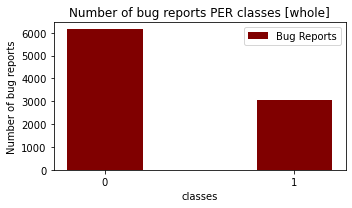

In [18]:
cds = {} # {"train": {"class0": num0, "class1": num1, ...}, "validation": {...}, ...}
# calculate class distribution for whole dataset
temp = df_main.groupby("bug_class_2").size()
cd_whole = temp.to_dict()
cd_whole = {str(key): value for key, value in cd_whole.items()}
cds["whole"] = cd_whole

# plot class distribution for whole dataset
wholeCD = ClassDistribution(cd_whole)
wholeCD.calc_ratios()
print("ratios     : ", wholeCD.ratios)
wholeCD.calc_percentage()
print("percentages: ", wholeCD.percentage)
wholeCD.plot_data("whole")

# I. Preprocessing

In [19]:
class Preprocessing():
    
    docMaxTokenNo_org = 0
    docMaxTokenNo_token_threshold = 0
    my_deleted_bug = {}
    
    docMaxLen = 0 # max keywords allowed
    w2vDic = {} # dic : {"w1": [0.1, 0.2, ...], "w2": [0.1, 0.3, ...], ...}
    paddingVector = np.zeros(300, dtype="float32")
    bugRepTokens = [] # [[w1, w2, w3, ...], [w1, w2, ...], ...]
    docMaxTokenNo = 0 # max doc len after vectorization
    vector_tfidf = [] # array of dictinaries: [{"w1": 0.1, "w2": 0.3, ...}, {}, ...]
    vector_em = [] # array of matrix : [ [w1Vector, w2Vector], [], ...] 
    
    
    def __init__(self, docMaxLen, token_threshold):
        self.docMaxLen = docMaxLen
        self.token_threshold = token_threshold
    
    
    # tfidf of corpuses words
    def load_tfidf(self, tfidf_path):
        with open(tfidf_path, "r") as filehandle:
            self.vector_tfidf = json.load(filehandle)
    
    
    def tokenize(self, texts):
        stop_words = set(stopwords.words("english"))
        excludedTokens = {"http", "url", "https"}
        
        # self.df.columns[0] : "description"
        for i, doc in enumerate(texts):
            thisTokens = []
            doc = doc.lower()
            for token in WordPunctTokenizer().tokenize(doc):
                if (token in string.punctuation or token in stop_words or token in excludedTokens or 
                    (not re.findall("\w", token)) or re.findall("\A[0-9]", token)):
                    continue
                thisTokens.append(token)
                self.w2vDic[token] = self.paddingVector
            if len(thisTokens) <= self.token_threshold:
                self.bugRepTokens.append(thisTokens)
                if (len(thisTokens) > self.docMaxTokenNo_token_threshold):
                    self.docMaxTokenNo_token_threshold = len(thisTokens)
            else:
                self.my_deleted_bug[i] = len(thisTokens)
                del labels[i]
                del self.vector_tfidf[i]
            if (len(thisTokens) > self.docMaxTokenNo_org):
                self.docMaxTokenNo_org = len(thisTokens)
    
    
    def loadW2V(self, w2vpath):
         with open(w2vpath, "rb") as f:
            header = f.readline()
            model_vocab_size, model_vector_size = map(int, header.split())
            binary_len = np.dtype("float32").itemsize * model_vector_size
            
            for line_no in range(model_vocab_size):
                word = []
                while True:
                    ch = f.read(1)
                    if ch == b" ":
                        break
                    if ch == b"":
                        raise EOFError("unexpected end of input; is count incorrect or file otherwise damaged?")
                    if ch != b"\n":
                        word.append(ch)
                word = b"".join(word).decode("utf-8")
                if (word in self.w2vDic.keys()):
                    self.w2vDic[word] = np.frombuffer(f.read(binary_len), dtype="float32")
                else:
                    f.seek(binary_len, 1)
    
    
    def vectorize_w2V (self, keywordBased=False):
        tempVec = []
        x = slice(0, self.docMaxLen)
        if keywordBased:
            print("keywordBased")
            for doc_tokens, doc_tfidf in zip(self.bugRepTokens, self.vector_tfidf):
                # docKeywords = [m for m in doc_tfidf.keys()][x]
                docKeywords = list(doc_tfidf.keys())[x]
                docAbs = self.getDocAbsrtract_(doc_tokens, docKeywords)
                tempVec = [self.w2vDic[term] for term in docAbs]
                self.vector_em.append(tempVec)
                if (len(tempVec) > self.docMaxTokenNo):
                    self.docMaxTokenNo = len(tempVec)
        else:
            print("NO keywordbased")
            for doc_tokens in self.bugRepTokens:
                tempVec = [self.w2vDic[term] for term in doc_tokens]
                self.vector_em.append(tempVec)
                if (len(tempVec) > self.docMaxTokenNo):
                    self.docMaxTokenNo = len(tempVec)
    
    
    def getDocAbsrtract_(self, doc_tok, docKeywords):
        return [t for t in doc_tok if t in docKeywords]
    
    
    def padding(self):
        for doc in self.vector_em:
            if (len(doc) < self.docMaxTokenNo):
                doc.extend([self.paddingVector] * (self.docMaxTokenNo - len(doc)))
    
    
    def freeMem(self):
        self.w2vDic = {}
        self.bugRepTokens = []
        self.vector_tfidf = []
        self.vector_em = []

## Vectorize

In [20]:
ds = Preprocessing(preprocessing_params["docMaxLen"], token_threshold)
ds.load_tfidf(mypaths["tfidf"]["output_vec"])
ds.tokenize(texts)

# --- vectorize: w2v (keywordbased or no)
print("loadW2V")
ds.loadW2V(mypaths["w2v"]["pre_trained_model"])

print("vectorize_w2V")
ds.vectorize_w2V(preprocessing_params["keyword_Based"])

ds.padding()

loadW2V
vectorize_w2V
keywordBased


In [21]:
model_params["longest_sentence_length"] = ds.docMaxTokenNo
model_params

{'filter_sizes': [3, 4, 5],
 'conv_kernel_output_channel': 64,
 'embedding_size': 300,
 'longest_sentence_length': 8256,
 'dropout_zero_prob': 0.5}

In [22]:
print("df_main length:                ", len(df_main))
print("bugRepTokens:                  ", len(ds.bugRepTokens))
print("vector_tfidf:                  ", len(ds.vector_tfidf))
print("num neglecting bugs:           ", len(ds.my_deleted_bug))
print("my_deleted_bug:                ", ds.my_deleted_bug)
print("docMaxTokenNo_org:             ", ds.docMaxTokenNo_org)
print("docMaxTokenNo_token_threshold: ", ds.docMaxTokenNo_token_threshold)
print("-" * 10)
print("docMaxTokenNo:                 ", ds.docMaxTokenNo)
print("ds.w2vDic:                     ", len(ds.w2vDic))
print("ds.vector_em:                  ", len(ds.vector_em))
print(len(ds.vector_em[0]))

df_main length:                 9201
bugRepTokens:                   9201
vector_tfidf:                   9201
num neglecting bugs:            0
my_deleted_bug:                 {}
docMaxTokenNo_org:              8463
docMaxTokenNo_token_threshold:  8463
----------
docMaxTokenNo:                  8256
ds.w2vDic:                      27969
ds.vector_em:                   9201
8256


In [23]:
print("len(texts):  ", len(texts))
print("len(labels): ", len(labels))

len(texts):   9201
len(labels):  9201


# II. Tensor Gen

In [ ]:
class MyToTensor(object):
    def __call__(self, sample_x):
        return torch.tensor(sample_x, dtype=torch.float32)

In [ ]:
class AddChannelDimension(object):
    def __call__(self, sample_x):
        return torch.unsqueeze(sample_x, 0)

In [ ]:
class MyDatasetTensor(Dataset):
    
    def __init__(self, vector_em, labels, transform=None):
        self.x = vector_em
        self.y = torch.tensor(labels, dtype=torch.long)
        self.len = len(self.y)
        self.transform = transform
        
    def __getitem__(self, index):
        my_x = self.x[index]
        my_x = np.array(my_x)
        if self.transform:
            my_x = self.transform(my_x)
        return my_x, self.y[index]
    
    def __len__(self):
        return self.len

## obj

In [ ]:
composed_transform = transforms.Compose([
    MyToTensor(),
    AddChannelDimension()
])

dsTen = MyDatasetTensor(ds.vector_em, labels, transform=composed_transform)
ds.freeMem()

# III. Split, Loader, Balance

In [ ]:
class MyDatasetSplit():
    def __init__(self, batch_size):
        self.mykeys = ["train", "validation"]
        self.my_datasets = {} # {"train": dataset0, "validation": dataset1}
        self.len_datasets = {} # {"train": len0, "validation": len1}
        self.my_dataloaders = {} # {"train": dataloader0, "validation": dataloader1}
        self.len_dataloaders = {} # {"train": len0, "validation": len1}
        self.batch_size = batch_size
        self.class_weights = None # [1, 4]
        self.sample_weights = None # [1, 1, 1, 4, 1, 4, ...]
    
    
    def split_dataset(self, dataset_tensor, train_percentage):
        dataset_tensor_len = len(dataset_tensor)
        train_size = int(train_percentage * dataset_tensor_len)
        validation_size = dataset_tensor_len - train_size
        
        rs = random_split(dataset_tensor, [train_size, validation_size])
        
        for i, k in enumerate(self.mykeys):
            self.my_datasets[k] = rs[i]
            self.len_datasets[k] = len(rs[i])
    
    
    # ******************** gen_train_balanced ********************
    
    def calc_class_weights_(self, ratios, num_classes):
        class_weights = [0] * num_classes
        keys = list(ratios.keys())[:num_classes - 1]
        max_class, _ = keys[0].split("/")
        class_weights[int(max_class)] = 1
        for key in keys:
            _, other_class = key.split("/")
            class_weights[int(other_class)] = round(ratios[key], 1)
        self.class_weights = class_weights
    
    
    def init_sample_weights_(self):
        sample_weights = [0] * self.len_datasets["train"]
        manager = enlighten.get_manager()
        prog = manager.counter(total=self.len_datasets["train"], desc="init_sample_weights", 
                               unit="sample", color="blue")
        for idx, (data, label) in enumerate(self.my_datasets["train"]):
            cw = self.class_weights[label]
            sample_weights[idx] = cw
            prog.update()
        self.sample_weights = sample_weights
    
    
    def gen_train_balanced(self, ratios, num_classes):
        # ---- balanced train dataloader
        # sampler
        self.calc_class_weights_(ratios, num_classes)
        self.init_sample_weights_()
        sampler = WeightedRandomSampler(self.sample_weights, num_samples=self.len_datasets["train"], replacement=True)
        # dataloader
        self.my_dataloaders["train_balanced"] = DataLoader(
            self.my_datasets["train"], 
            batch_size=self.batch_size, 
            sampler=sampler
        )
        self.len_dataloaders["train_balanced"] = len(self.my_dataloaders["train_balanced"])
        self.len_datasets["train_balanced"] = self.len_datasets["train"]
    
    
    # ******************** gen_dataloaders ********************
    
    def gen_dataloaders(self):
        # ---- dataloaders
        for k in self.mykeys:
            self.my_dataloaders[k] = DataLoader(
                self.my_datasets[k], 
                batch_size=self.batch_size, 
                shuffle=True
            )
            self.len_dataloaders[k] = len(self.my_dataloaders[k])
    
    
    def freeMem(self):
        self.my_datasets = None
        self.sample_weights = None

## obj

In [ ]:
dsTenSplit = MyDatasetSplit(dataset_params["batch_size"])

dsTenSplit.split_dataset(dsTen, dataset_params["train_size"])

if dataset_params["balance_train"]:
    print("-" * 15, "gen_train_balanced")
    dsTenSplit.gen_train_balanced(wholeCD.ratios, preprocessing_params["num_bug_classes"])

dsTenSplit.gen_dataloaders()
dsTenSplit.freeMem()
os.system("printf '\a'")

In [ ]:
dsTenSplit.class_weights

# BatchClassDistribution

- calculate `batches` class distribution for **a dataloader**
    - and then visualize it.

- calculate `total` class distribution for **a dataloader**

In [ ]:
class BatchClassDistribution():
    
    def __init__(self, num_classes, colours):
        # [{"label": "class0", "values": [num_class0inbatch0, num_class0inbatch1 , ...], "colour": "colour0"}, ...]
        self.batch_class_distributions = [] 
        
        # {"class0": num1, "class1": num2, ...}
        self.class_distributions = {}
        
        for i in range(num_classes):
            temp = {
                "label": str(i),
                "values": [],
                "colour": colours[i]
            }
            self.batch_class_distributions.append(temp)
            
        self.num_classes = num_classes
        self.len_dataloader = None
    
    
    # ************************ batches class distribution for a dataloader ************************
    
    def calc_batch_class_distributions(self, data_loader, batch_size):
        manager = enlighten.get_manager()
        prog = manager.counter(total=len(data_loader), desc="calc_batch_class_distributions", 
                               unit="batch", color="gray")
        
        self.len_dataloader = len(data_loader)
        
        maxlen = len(str(batch_size))
        for _, y in data_loader:
            count = Counter(y.numpy())
            tempBCD_formated = []
            
            for i in range(self.num_classes):
                tempDist = count[i] if i in count.keys() else 0
                self.batch_class_distributions[i]["values"].append(tempDist)
            
            prog.update()
    
    
    def plot_batch_class_distribution(self, dataName, start_range=None, end_range=None):
        bar_scale = 0.8
        
        start_range = start_range if start_range else 0
        end_range = end_range if end_range else self.len_dataloader
        myindex = slice(start_range, end_range)
        num_sample = end_range - start_range
        
        fig, ax = plt.subplots(figsize=(14, 4))
        
        for i, data in enumerate(self.batch_class_distributions):
            # the label locations
            temp = self.num_classes - 1
            temp = temp / 2
            temp = (i - temp) * bar_scale
            temp = temp / self.num_classes
            temp = np.arange(self.len_dataloader) + temp
            x = 1 + temp
            
            ax.bar(
                x=x[myindex],
                height=data["values"][myindex],
                width=bar_scale / self.num_classes,
                label=data["label"],
                color=data["colour"],
                linewidth=0.5,
            )
        
        ax.get_xaxis().set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel("Number of samples")
        ax.set_xlabel("batch numbers")
        ax.set_title("Number of class samples PER batch [{}]".format(dataName))
        ax.legend()
        fig.tight_layout()
    
    
    # ************************ total class distribution for a dataloader ************************
    
    def calc_class_distributions(self):
        for cl in self.batch_class_distributions:
            temp = sum(cl["values"])
            key = cl["label"]
            self.class_distributions[key] = temp

## obj

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

In [ ]:
for dataName in dsTenSplit.my_dataloaders.keys():
    # calculate batches class distribution for a dataloader
    print("-" * 15, dataName)
    tempBCD = BatchClassDistribution(preprocessing_params["num_bug_classes"], bcd_colours)
    tempBCD.calc_batch_class_distributions(dsTenSplit.my_dataloaders[dataName], dataset_params["batch_size"])
    
    # plot batches class distribution for a dataloader
    tempBCD.plot_batch_class_distribution(dataName, start_range=None, end_range=None)
    
    # calculate total class distribution for a dataloader
    tempBCD.calc_class_distributions()
    cds[dataName] = tempBCD.class_distributions
    
    # plot totlal class distribution for a dataloader
    tempCDist = ClassDistribution(tempBCD.class_distributions)
    tempCDist.calc_ratios()
    print("ratios     : ", tempCDist.ratios)
    tempCDist.calc_percentage()
    print("percentages: ", tempCDist.percentage)
    tempCDist.plot_data(dataName)
    print("\n")
os.system("printf '\a'")

# Model

In [ ]:
class CNN(nn.Module):
    
    # Constructor
    def __init__(self, 
                 filter_sizes, 
                 conv_kernel_output_channel, 
                 embedding_size,
                 longest_sentence_length, 
                 num_classes, 
                 dropout_keep_prob):
        
        super(CNN, self).__init__()
        
        # cnn and maxpool layers
        self.cnns = nn.ModuleList()
        self.maxpools = nn.ModuleList()
        
        self.cnn_list = []
        self.maxpool_list = []
        
        for i, filter_size in enumerate(filter_sizes):
            cnn_ = nn.Conv2d(in_channels=1, 
                             out_channels=conv_kernel_output_channel, 
                             kernel_size=(filter_size, embedding_size), 
                             stride=1, 
                             padding=0)
            # initialize cnn weights and biases
            torch.nn.init.trunc_normal_(cnn_.weight, std=0.1)
            torch.nn.init.constant_(cnn_.bias, 0.1)
            
            maxpool_ = nn.MaxPool2d(kernel_size=(longest_sentence_length - filter_size + 1, 1), 
                                    stride=1, 
                                    padding=0)
            self.cnns.append(cnn_)
            self.maxpools.append(maxpool_)
            
        # droput layer
        self.drop = nn.Dropout(p = dropout_keep_prob)
        
        # fully connected layer
        self.fc1 = nn.Linear(conv_kernel_output_channel * len(filter_sizes), num_classes)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.constant_(self.fc1.bias, 0.1)
        
        self.filter_sizes = filter_sizes
        
    # Prediction
    def forward(self, x):
        
        self.pooled_outputs = []
        
        for i, filter_size in enumerate(self.filter_sizes):
            x1 = self.cnns[i](x) # convolution layer
            x1 = torch.relu(x1) # apply activation function
            x1 = self.maxpools[i](x1) # maxpooling layer
            self.pooled_outputs.append(x1)
        
        # flatten or reshape the output
        x1 = torch.cat(self.pooled_outputs, 1)
        x1 = x1.view(x1.size(0), -1)
        
        # dropout
        x1 = self.drop(x1)
        
        # fully connected layer
        x1 = self.fc1(x1)
        
        # no softmax at the end, because cross entropy loss have it implicitly
        
        return x1

# Train, Validate, Test

## MyConfusionMatrix

In [ ]:
class MyConfusionMatrix():
    def __init__(self, num_classes):
        # rows: actual, columns: prediction
        self.confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    
    def update(self, y, yhat_indices):
        for actual, pred in zip(y, yhat_indices):
                self.confusion_matrix[actual, pred] += 1
    
    
    def calc_accuracy(self):
        diagon = self.confusion_matrix.diagonal()
        # accuracy
        total_samples = self.confusion_matrix.sum()
        total_corrects = diagon.sum()
        accuracy = 100 * (total_corrects / total_samples)
        
        # accuracy per class
        # sum(1): 1 referes to sum for each row
        samples_per_class = self.confusion_matrix.sum(1)
        accuracy_per_class = 100 * (np.divide(diagon, samples_per_class))
        
        return accuracy, accuracy_per_class.tolist()
    
    
    def get_cf(self):
        return self.confusion_matrix.tolist()

## MyTrain

In [ ]:
class MyTrain():
    
    def __init__(self, train_params, num_classes):
        self.train_params = train_params
        self.num_classes = num_classes
        
        self.model = None
        
        self.criterion = None
        self.l2_loss = 0.0
        
        self.optimizer = None
        self.decay_speed = None
        self.counter = 0
        
        self.progresses = None
        
        self.best_model_wts = None
        self.useful_stuff = {
            "train": {
                "confusion_matrix": [], 
                "accuracy": [], 
                "acc_per_class": [], 
                "cost": [] 
            }, 
            "validation": {
                "confusion_matrix": [], 
                "accuracy": [], 
                "best_acc": 0.0, 
                "best_at_step": 0, 
                "acc_per_class": [], 
                "cost": []
            }
        }
    
    
    # ************************** model, criterion, optimization ************************** #
    
    def create_model(self, model_params):
        self.model = CNN(
            model_params["filter_sizes"], 
            model_params["conv_kernel_output_channel"], 
            model_params["embedding_size"], 
            model_params["longest_sentence_length"], 
            self.num_classes, 
            model_params["dropout_zero_prob"])
        if torch.cuda.is_available():
            print("Available")
            self.model = self.model.cuda()
        print("my_model: ", self.model)
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
    
    
    def create_criterion_optimization(self):
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.train_params["max_learning_rate"])
    
    
    # ************************** learning rate ************************** #
    
    def lr_init_decay_speed(self, batch_size, len_dataset_train):
        self.decay_speed = self.train_params["decay_coefficient"] * len_dataset_train / batch_size
    
    
    def lr_update_(self):
        # compute learning rate for each batch.
        # max value of counter is: epoch * number of batches
        # self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate) * math.exp(-counter / self.decay_speed)
        temp_lr = (self.train_params["max_learning_rate"] - self.train_params["min_learning_rate"])
        temp_lr = temp_lr * math.exp(-self.counter / self.decay_speed)
        temp_lr = temp_lr + self.train_params["min_learning_rate"]
        self.counter += 1
        return temp_lr
    
    
    # ************************** progress lines ************************** #
    
    def progress_lines(self, len_dataloaders, colours):
        total = [self.train_params["epochs"], len_dataloaders["train"], len_dataloaders["validation"]]
        desc = ["epoch", "train", "validation"]
        unit = ["epoch", "batch", "batch"]
        temp_desc = self.set_strings_to_equal_len_(desc)
        unit = self.set_strings_to_equal_len_(unit)
        
        manager = enlighten.get_manager()
        progresses = {}
        for i in range(len(total)):
            prog = manager.counter(total=total[i], desc=temp_desc[i], unit=unit[i], color=colours[i])
            progresses[desc[i]] = prog
        self.progresses = progresses
    
    
    def set_strings_to_equal_len_(self, words):
        max_len = 0
        longest_string_length = len(max(words, key=len))
        w = []
        for i, word in enumerate(words):
            temp = longest_string_length - len(word)
            w.append(word + " " * temp)
        return w
    
    
    # ************************** epoch ************************** #
    
    def epoch_train_validate(self, train_dataloader, validation_dataloader):
        for epoch in range(self.train_params["epochs"]):
            self.progresses["train"].refresh()
            self.progresses["validation"].refresh()
            
            self.train_model_(train_dataloader)
            self.validate_model_(validation_dataloader, epoch)
            
            self.progresses["epoch"].update()
        
        # load best model weights
        self.model.load_state_dict(self.best_model_wts)
    
    # ================================================================== #
    #                            Train section                           #
    # ================================================================== #
    
    def train_model_(self, train_dataloader):
        self.model.train() # Set model to training mode
        cost = 0.0
        # rows: actual, columns: prediction
        confusion_matrix = MyConfusionMatrix(self.num_classes)
        
        for x, y in train_dataloader:
            if torch.cuda.is_available(): # Transfer Data to GPU if available
                x, y = x.cuda(), y.cuda()
            
            # forward / prediction
            yhat = self.model(x) # make a prediction
            loss = self.criterion(yhat, y) # calculate loss
            
            # L2-regularization
            # just apply on the last layer (Linear layer) of the cnn model 
            my_w = self.model.fc1.weight
            my_b = self.model.fc1.bias
            self.l2_loss = 0.0
            self.l2_loss += torch.sum(my_w ** 2) / 2
            self.l2_loss += torch.sum(my_b ** 2) / 2
            loss = loss + self.train_params["l2_reg_lambda"] * self.l2_loss
            
            # backwards
            self.optimizer.zero_grad() # clear gradient
            self.optimizer.param_groups[0]["lr"] = self.lr_update_() # update learning rate
            loss.backward() # calculate gradients of parameters
            self.optimizer.step() # update parameters
            
            # accumulate loss and num_correct
            # we refer to "accumulated loss" as "cost"
            cost += loss.item()
            
            _, yhat_indices = torch.max(yhat.data, 1)
            confusion_matrix.update(y, yhat_indices)
            
            self.progresses["train"].update()
        # ----- end for
        
        # save cost, accuracy
        train_accuracy, acc_per = confusion_matrix.calc_accuracy()
        self.useful_stuff["train"]["confusion_matrix"].append(confusion_matrix.get_cf())
        self.useful_stuff["train"]["accuracy"].append(train_accuracy)
        self.useful_stuff["train"]["acc_per_class"].append(acc_per)
        self.useful_stuff["train"]["cost"].append(cost)
        self.progresses["train"].count = 0
    
    # ================================================================== #
    #                          Validate section                          #
    # ================================================================== #
    
    def validate_model_(self, validation_dataloader, epoch):
        self.model.eval() # Set model to evaluate mode
        cost = 0.0
        confusion_matrix = MyConfusionMatrix(self.num_classes)
        
        with torch.no_grad():
            for x, y in validation_dataloader:
                if torch.cuda.is_available():
                    x, y = x.cuda(), y.cuda()

                # prediction
                yhat = self.model(x)
                loss = self.criterion(yhat, y)

                # accumulate loss and Confusion Matrix
                cost += loss.item()
                
                _, yhat_indices = torch.max(yhat.data, 1)
                confusion_matrix.update(y, yhat_indices)
                
                self.progresses["validation"].update()
            # ----- end for
            
            # save cost, accuracy and model
            val_accuracy, acc_per = confusion_matrix.calc_accuracy()
            if val_accuracy > self.useful_stuff["validation"]["best_acc"]:
                self.useful_stuff["validation"]["best_acc"] = val_accuracy
                self.useful_stuff["validation"]["best_at_step"] = epoch + 1
                self.best_model_wts = copy.deepcopy(self.model.state_dict())
            
            self.useful_stuff["validation"]["confusion_matrix"].append(confusion_matrix.get_cf())
            self.useful_stuff["validation"]["accuracy"].append(val_accuracy)
            self.useful_stuff["validation"]["acc_per_class"].append(acc_per)
            self.useful_stuff["validation"]["cost"].append(cost)
            self.progresses["validation"].count = 0
    
    
    # ************************** save ************************** #
    
    def save_to_file_model(self, model_path):
        torch.save(self.model.state_dict(), model_path)
    
    
    def save_to_file_results(self, dataset_name, preprocessing_params, dataset_params, class_distributions, 
                             model_params, result_path, ):
        tempStructure = {
            "dataset": dataset_name,
            "preprocessing_params": preprocessing_params,
            "dataset_params": dataset_params,
            "model_params": model_params,
            "train_params": self.train_params,
            "class_distributions": class_distributions,
            "model_results": self.useful_stuff
        }
        
        # time to train
        totalSeconds = self.progresses["epoch"].elapsed
        hours = int(totalSeconds / 3600)
        minutes = int((totalSeconds - (hours * 3600)) / 60)
        seconds = int((totalSeconds - (hours * 3600 + minutes * 60)))
        tempStructure["model_results"]["time_to_train"] = f"{hours}h:{minutes}m:{seconds}s"
        
        with open(result_path, "w") as fout:
            json.dump(tempStructure, fout)

## flow_train_on_data

In [ ]:
def flow_train_on_data(dataName, file_subversion):
    mtr = MyTrain(train_params, preprocessing_params["num_bug_classes"])

    # -------- model, criterion, optimization
    print("*" * 15, "model, criterion, optimization")
    mtr.create_model(model_params)
    mtr.create_criterion_optimization()

    # -------- learning rate
    print("*" * 15, "lr_init_decay_speed")
    mtr.lr_init_decay_speed(
        dataset_params["batch_size"], 
        dsTenSplit.len_datasets["train"]
    )

    # -------- progress lines
    print("*" * 15, "train on", file_subversion)
    mtr.progress_lines(
        dsTenSplit.len_dataloaders, 
        ["black", "blue", "gray", "lightskyblue1"]
    )

    # -------- epoch
    mtr.epoch_train_validate(
        dsTenSplit.my_dataloaders[dataName], 
        dsTenSplit.my_dataloaders["validation"]
    )
    
    # -------- save
    if preprocessing_params["keyword_Based"]:
        prefix = "tfidf"
    else:
        prefix = "w2v"
    # model
    model_path = mypaths[prefix]["output_model"].format(file_subversion)
    mtr.save_to_file_model(model_path)
    
    # result
    result_path = mypaths[prefix]["output_performance"].format(file_subversion)
    mtr.save_to_file_results(mypaths["dataset"], 
                             preprocessing_params, 
                             dataset_params, 
                             cds, 
                             model_params, 
                             result_path)
    # return mtr

## call

In [ ]:
# train on imbalance data
flow_train_on_data("train", mypaths["file_subversion"]["im"])

In [ ]:
# train on balanced data
if "train_balanced" in dsTenSplit.my_dataloaders:
    flow_train_on_data("train_balanced", mypaths["file_subversion"]["ba"])